In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Dense, Dropout, BatchNormalization, Add
from sklearn.utils import class_weight
# Evaluate accuracy and F1 score
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt

# Load the LIAR dataset
train_data = pd.read_csv('train_LIAR.tsv', sep='\t', header=None)
test_data = pd.read_csv('test_LIAR.tsv', sep='\t', header=None)
valid_data = pd.read_csv('valid_LIAR.tsv', sep='\t', header=None)

# Assign column names
columns = [
    'id', 'label', 'statement', 'subject', 'speaker', 'job_title', 
    'state_info', 'party_affiliation', 'barely_true_counts', 
    'false_counts', 'half_true_counts', 'mostly_true_counts', 
    'pants_on_fire_counts', 'context'
]
train_data.columns = columns
test_data.columns = columns
valid_data.columns = columns

# Combine all data for preprocessing
data = pd.concat([train_data, test_data, valid_data], ignore_index=True)

# Display the first few rows
#print(data.head())

In [2]:
print("Length of training set:", len(train_data))
print("Length of validation set:", len(valid_data))
print("Length of test set:", len(test_data))

Length of training set: 10240
Length of validation set: 1284
Length of test set: 1267


In [3]:
from sklearn.decomposition import PCA, TruncatedSVD
#train_data.columns = columns
#data = train_data

# Simulate engagements (η) and timestamps (∆t)
np.random.seed(42)
data['engagements'] = np.random.randint(1, 100, size=len(data))  # Simulate number of engagements
data['timestamp'] = np.random.randint(0, 1000, size=len(data))  # Simulate timestamps

# Generate doc2vec embeddings for the text
documents = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(data['statement'])]
doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=1, workers=4)
data['text_vector'] = [doc2vec_model.infer_vector(text.split()) for text in data['statement']]

# Extract user features using SVD
# Create a user-article matrix (simulated)
user_article_matrix = pd.crosstab(data['speaker'], data['id'])  # Speaker-article engagement matrix
svd = TruncatedSVD(n_components=20)  # Reduce to 20 dimensions
user_features = svd.fit_transform(user_article_matrix)

# Map user features back to the dataset
user_feature_dict = {speaker: features for speaker, features in zip(user_article_matrix.index, user_features)}
data['user_features'] = data['speaker'].map(user_feature_dict)

# Drop rows with missing user features (if any)
#data = data.dropna(subset=['user_features'])
# Example: Drop rows with missing values in both features and labels


In [4]:
# Convert labels to binary (true/false)
# LIAR has multiple labels: true, mostly-true, half-true, barely-true, false, pants-on-fire
# We can map them to binary labels (0 for fake, 1 for true)
label_mapping = {
    'true': 1,
    'mostly-true': 1,
    'half-true': 0,
    'barely-true': 0,
    'false': 0,
    'pants-on-fire': 0
}

#data = full_data.copy()  # Explicitly create a copy to avoid warnings
data['label_binary'] = data['label'].map(label_mapping)
#data.loc[:, 'label_binary'] = data['label'].map(label_mapping)
data = data.dropna(subset=['label_binary'])  # Drop rows where 'label_binary' is NaN
# Check class distribution

#print(data['label_binary'].value_counts())
data = data.dropna(subset=['user_features', 'label_binary'])
print(data['label_binary'].value_counts())

# Prepare input data
# X_text = np.array(data['text_vector'].tolist())
# X_user = np.array(data['user_id'].tolist())
# X_time = np.array(data['timestamp'].tolist())
# y = np.array(data['label_binary'].tolist())

from sklearn.utils import class_weight

# Compute class weights
class_weights = class_weight.compute_class_weight(
    'balanced', 
    classes=np.unique(data['label_binary']), 
    y=data['label_binary']
)
class_weights = dict(zip(np.unique(data['label_binary']), class_weights))

#class_weights = {0: 1, 1: 1.5}
print("Class weights:", class_weights)



0.0    7235
1.0    4507
Name: label_binary, dtype: int64
Class weights: {0.0: 0.8114720110573601, 1.0: 1.3026403372531616}


In [5]:
# Split the data back into training, validation, and test sets
train_data = data[data['id'].isin(train_data['id'])]
valid_data = data[data['id'].isin(valid_data['id'])]
test_data = data[data['id'].isin(test_data['id'])]

# Function to prepare input data
def prepare_input_data(data):
    X_user_features = np.array(data['user_features'].tolist())  # User features (x_u)
    y = data['label_binary'].values  # Binary labels
    return X_user_features, y

# Prepare input data for training, validation, and test sets
X_train, y_train = prepare_input_data(train_data)
X_val, y_val = prepare_input_data(valid_data)
X_test, y_test = prepare_input_data(test_data)

#Building and Training the Score Module
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
#Building and Training the Score Module
print("Shape of X_train:", X_val.shape)
print("Shape of y_train:", y_val.shape)
#Building and Training the Score Module
print("Shape of X_train:", X_test.shape)
print("Shape of y_train:", y_test.shape)



Shape of X_train: (9399, 20)
Shape of y_train: (9399,)
Shape of X_train: (1168, 20)
Shape of y_train: (1168,)
Shape of X_train: (1175, 20)
Shape of y_train: (1175,)


In [6]:
# Partition the data into time intervals (e.g., hourly)
data['time_partition'] = data['timestamp'] // 3600  # Simulate hourly partitions
#data.loc[:, 'time_partition'] = data['timestamp'] // 100  # Simulate hourly partitions

# Aggregate features for each partition
partitioned_data = data.groupby(['id', 'time_partition']).agg({
    'user_features': lambda x: np.mean(x.tolist(), axis=0),  # Average user features
    'text_vector': lambda x: np.mean(x.tolist(), axis=0),    # Average text vector
    'engagements': 'sum',                                    # Total engagements (η)
    'timestamp': lambda x: (x.max() - x.min())               # Time between partitions (∆t)
}).reset_index()

#partitioned_data = data.groupby(['id', 'time_partition']).agg({
#     'user_features': lambda x: np.mean(np.vstack(x)),  # Average user features
#     'text_vector': lambda x: np.mean(np.vstack(x)),    # Average text vector
#     'engagements': 'sum',                             # Total engagements
#     'timestamp': lambda x: (x.max() - x.min())        # Time between partitions
# }).reset_index()

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Reshape

def build_capture_module(user_feature_dim=20, text_vector_dim=100, embedding_dim=100, lstm_units=128):
    # Input layers
    eta_input = Input(shape=(1,), name='eta_input')  # Number of engagements (η)
    delta_t_input = Input(shape=(1,), name='delta_t_input')  # Time between partitions (∆t)
    user_features_input_capture = Input(shape=(user_feature_dim,), name='user_features_input_capture')  # User features (x_u)
    text_vector_input = Input(shape=(text_vector_dim,), name='text_vector_input')  # Text vector (x_τ)

    # Embedding layer to standardize inputs
    eta_embedded = Dense(embedding_dim, activation='tanh')(eta_input)
    delta_t_embedded = Dense(embedding_dim, activation='tanh')(delta_t_input)
    user_features_embedded = Dense(embedding_dim, activation='tanh')(user_features_input_capture)
    text_vector_embedded = Dense(embedding_dim, activation='tanh')(text_vector_input)

    # Concatenate all embedded features
    concatenated = Concatenate()([eta_embedded, delta_t_embedded, user_features_embedded, text_vector_embedded])

    # Reshape for LSTM input (add timesteps dimension)
    reshaped = Reshape((1, embedding_dim * 4))(concatenated)

    # LSTM layer to capture temporal patterns
    lstm_output = LSTM(lstm_units, return_sequences=False)(reshaped)

    # Output vector v_j
    v_j = Dense(embedding_dim, activation='tanh')(lstm_output)

    # Define the model
    model = Model(inputs=[eta_input, delta_t_input, user_features_input_capture, text_vector_input], outputs=v_j)
    return model

In [8]:
# # Extract features from partitioned data
# X_eta = np.array(partitioned_data['engagements'].tolist()).reshape(-1, 1)  # Number of engagements (η)
# X_delta_t = np.array(partitioned_data['timestamp'].tolist()).reshape(-1, 1)  # Time between partitions (∆t)
# X_user_features = np.array(partitioned_data['user_features'].tolist())  # User features (x_u)
# X_text_vector = np.array(partitioned_data['text_vector'].tolist())  # Text vector (x_τ)

# Extract features from partitioned data
X_eta = np.array(partitioned_data['engagements'].tolist()).reshape(-1, 1)  # Number of engagements (η)
X_delta_t = np.array(partitioned_data['timestamp'].tolist()).reshape(-1, 1)  # Time between partitions (∆t)
X_user_features = np.array(partitioned_data['user_features'].tolist())  # User features (x_u)
X_text_vector = np.array(partitioned_data['text_vector'].tolist())  # Text vector (x_τ)

# Check the shapes of the input data
print("Shape of X_eta:", X_eta.shape)  # Should be (n_samples, 1)
print("Shape of X_delta_t:", X_delta_t.shape)  # Should be (n_samples, 1)
print("Shape of X_user_features:", X_user_features.shape)  # Should be (n_samples, 20)
print("Shape of X_text_vector:", X_text_vector.shape)  # Should be (n_samples, 100)

Shape of X_eta: (11742, 1)
Shape of X_delta_t: (11742, 1)
Shape of X_user_features: (11742, 20)
Shape of X_text_vector: (11742, 100)


In [9]:
# Build the Capture module
capture_model = build_capture_module(user_feature_dim=20, text_vector_dim=100)  # Adjust dimensions
capture_model.compile(optimizer='adam', loss='mse')  # Use MSE for regression tasks
y_train_cap = data['label_binary']

    
capture_model.fit([X_eta, X_delta_t, X_user_features, X_text_vector], 
                  y_train_cap, epochs=10, batch_size=32)

# Generate output vectors v_j
v_j = capture_model.predict([X_eta, X_delta_t, X_user_features, X_text_vector])
print("Output vectors v_j:", v_j)

Epoch 1/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2505
Epoch 2/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2360
Epoch 3/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2373
Epoch 4/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2376
Epoch 5/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2364
Epoch 6/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2348
Epoch 7/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2366
Epoch 8/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2360
Epoch 9/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2362
Epoch 10/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2350
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Output vectors v_j: [[0.20236698 0.24337853 0.24148625 ... 0.22562815 0.2581063  0.2180113 ]
 [0.40378895 0.4059965  0.40399548 ... 0.408492   0.4094409  0.4078367 ]
 [0.3669303  0.3660879  0.3590335  ... 0.369748   0.36371508 0.3633415 ]
 ...
 [0.41255805 0.41593903 0.4130471  ... 0.417

In [10]:
# # # Extract v_j from the Capture Module
# # v_j_train = capture_model.predict([X_eta_train, X_delta_t_train, X_user_features_train, X_text_vector_train])
# # v_j_test = capture_model.predict([X_eta_test, X_delta_t_test, X_user_features_test, X_text_vector_test])

# # print("Shape of v_j (train):", v_j_train.shape)
# # print("Shape of v_j (test):", v_j_test.shape)

# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, f1_score

# # Train Logistic Regression on v_j
# clf = LogisticRegression()
# clf.fit(v_j_train, y_train)

# # Predict on test set
# y_pred = clf.predict(v_j_test)

# # Evaluate
# acc = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print(f"Capture Module Evaluation -> Accuracy: {acc:.4f}, F1-score: {f1:.4f}")


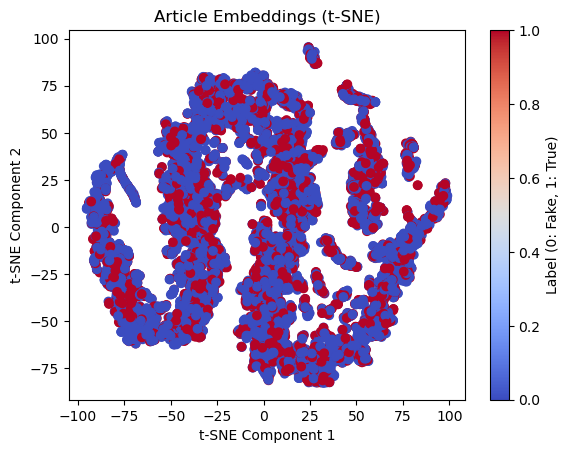

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
v_j_2d = tsne.fit_transform(v_j)

# # Reduce v_j to 2 dimensions
# pca = PCA(n_components=2)
# v_j_2d = pca.fit_transform(v_j)

# Plot the articles
#plt.scatter(v_j_2d[:, 0], v_j_2d[:, 1])
plt.scatter(v_j_2d[:, 0], v_j_2d[:, 1], c=data['label_binary'], cmap='coolwarm')
# plt.title("Article Embeddings (2D)")
# plt.xlabel("PCA Component 1")
# plt.ylabel("PCA Component 2")
plt.title("Article Embeddings (t-SNE)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label='Label (0: Fake, 1: True)')
plt.show()

In [12]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
# # Train a classifier on v_j
# classifier = LogisticRegression(class_weight=class_weights)
# classifier.fit(v_j, data['label_binary'])

# # Evaluate
# y_pred = classifier.predict(v_j)
# print(classification_report(data['label_binary'], y_pred))

from imblearn.over_sampling import SMOTE

# Extract features (v_j) and labels
X = v_j  # The output vectors from the Capture module
y = data['label_binary']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train the classifier on the resampled dataset
classifier = LogisticRegression(class_weight='balanced')  # No need for manual class weights now
classifier.fit(X_resampled, y_resampled)

# Evaluate
y_pred = classifier.predict(X_resampled)
print(classification_report(y_resampled, y_pred))

              precision    recall  f1-score   support

         0.0       0.53      0.45      0.49      7235
         1.0       0.53      0.61      0.56      7235

    accuracy                           0.53     14470
   macro avg       0.53      0.53      0.53     14470
weighted avg       0.53      0.53      0.53     14470



In [13]:
# # print("Length of v_j:", len(v_j))
# # print("Length of labels:", len(data['label_binary']))

# # Example: Ensure y_pred corresponds to the test set labels
# y_test = test_data['label_binary'].values
# print("Length of y_test:", len(y_test))
# print("Length of y_pred:", len(y_pred))

In [14]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# # Compute confusion matrix
# cm = confusion_matrix(data['label_binary'], y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
# disp.plot()
# plt.show()

# Score Module

In [15]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Add
from tensorflow.keras.regularizers import l2


def build_score_module(user_feature_dim=20):
    # Input layer for user features
    user_features_input_score = Input(shape=(user_feature_dim,), name='user_features_input_score')

    # Fully connected layer to extract user representations
    #user_representation = Dense(embedding_dim, activation='tanh')(user_features_input)

    # Fully connected layers
    hidden_layer_1 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(user_features_input_score)
    hidden_layer_1 = BatchNormalization()(hidden_layer_1)
    hidden_layer_1 = Dropout(0.2)(hidden_layer_1)

    hidden_layer_2 = Dense(128, activation='relu')(hidden_layer_1)
    hidden_layer_2 = BatchNormalization()(hidden_layer_2)
    hidden_layer_2 = Dropout(0.2)(hidden_layer_2)

    hidden_layer_3 = Dense(64, activation='relu')(hidden_layer_2)
    hidden_layer_3 = BatchNormalization()(hidden_layer_3)
    hidden_layer_3 = Dropout(0.2)(hidden_layer_3)


    # Scalar score s_i for each user
    user_score = Dense(1, activation='sigmoid', name='user_score')(hidden_layer_3)
    
    # Scalar score s_i for each user
    #user_score = Dense(1, activation='sigmoid', name='user_score')(user_representation)

    # Define the model
    model = Model(inputs=user_features_input_score, outputs=user_score)
    return model

In [16]:
import numpy as np
from imblearn.over_sampling import SMOTE

y_train = y_train.astype(int)

# Check for None values
print("Number of None values in X_train:", np.sum([x is None for x in X_train]))
print("Number of None values in y_train:", np.sum([y is None for y in y_train]))

# Ensure X_train and y_train are numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Verify data types
print("Type of X_train:", type(X_train))
print("Type of y_train:", type(y_train))

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

print("Unique values in y_train:", np.unique(y_train))

# Ensure X_train is numeric (no categorical data)
#print("Sample of X_train:", X_train[:5])

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print("Balanced class distribution:", np.bincount(y_train_balanced))


# from imblearn.under_sampling import RandomUnderSampler

# # Apply SMOTE to Class 0 & Undersample Class 1
# undersample = RandomUnderSampler(sampling_strategy=0.7, random_state=42)  
# X_train_undersampled, y_train_undersampled = undersample.fit_resample(X_train, y_train)

# smote = SMOTE(sampling_strategy=0.9, random_state=42)
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train_undersampled, y_train_undersampled)

# print("Class distribution after balancing:", np.bincount(y_train_balanced))

Number of None values in X_train: 0
Number of None values in y_train: 0
Type of X_train: <class 'numpy.ndarray'>
Type of y_train: <class 'numpy.ndarray'>
Shape of X_train: (9399, 20)
Shape of y_train: (9399,)
Unique values in y_train: [0 1]
Balanced class distribution: [5761 5761]


In [17]:
score_model = build_score_module(user_feature_dim=20)
#score_model.compile(optimizer='adam', loss='binary_crossentropy')  # Use binary cross-entropy for classification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#optimizer = Adam(learning_rate=0.001) #accuracy: 0.5222 - loss: 0.6862 - val_accuracy: 0.3981 - val_loss: 0.6920 - learning_rate: 1.2500e-04
#optimizer = Adam(learning_rate=0.01) #accuracy: 0.4987 - loss: 0.6934 - val_accuracy: 0.6404 - val_loss: 0.6881 - learning_rate: 0.0050
from tensorflow.keras.optimizers import RMSprop

#optimizer = RMSprop(learning_rate=0.01) #accuracy: 0.5164 - loss: 0.6929 - val_accuracy: 0.6404 - val_loss: 0.6903 - learning_rate: 0.0050
optimizer = RMSprop(learning_rate=0.001) #accuracy: 0.5234 - loss: 0.6910 - val_accuracy: 0.3844 - val_loss: 0.7002 - learning_rate: 5.0000e-04
#optimizer = RMSprop(learning_rate=0.0001) #Best so far

score_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# import tensorflow.keras.backend as K

# def focal_loss(gamma=2., alpha=0.25):
#     def loss(y_true, y_pred):
#         y_true = K.cast(y_true, K.floatx())
#         y_pred = K.clip(y_pred, 1e-7, 1.0 - 1e-7)
#         return -K.mean(alpha * y_true * K.pow(1 - y_pred, gamma) * K.log(y_pred) +
#                        (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma) * K.log(1 - y_pred))
#     return loss

# score_model.compile(optimizer=optimizer, loss=focal_loss(), metrics=['accuracy'])


# # Check for NaN or infinite values
# print("NaN values in X_user_features_score:", np.isnan(X_user_features_score).sum())
# print("Infinite values in X_user_features_score:", np.isinf(X_user_features_score).sum())
# print("NaN values in y_train_score:", np.isnan(y_train_score).sum())
# print("Infinite values in y_train_score:", np.isinf(y_train_score).sum())


# # Compute class weights
# unique_classes = np.unique(y_train_score)
# class_weights = class_weight.compute_class_weight('balanced', classes=unique_classes, y=y_train_score)
# class_weights = dict(zip(unique_classes, class_weights)http://localhost:8888/notebooks/CSI-actual.ipynb#)

# Compute class weights
#class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_balanced), y=y_train_balanced)
#class_weights = dict(zip(np.unique(y_train_balanced), class_weights))
#class_weights = {0: 2.0, 1: 1.0}  # Increase minority class weight


# Check class distribution
print("Class distribution:", np.bincount(y_train_balanced))
print("Class weights:", class_weights)

# # Ensure all possible classes are included in class_weights
# all_classes = [0, 1]  # Assuming binary classification
# for cls in all_classes:
#     if cls not in class_weights:
#         class_weights[cls] = 1.0  # Default weight for missing classes

# # Print class_weights for debugging
# print("Class weights:", class_weights)
        

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)    
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

#score_model.fit(X_user_features_score, y_train_score, epochs=10, batch_size=32, class_weight=class_weights)  
    
# Train the model
history = score_model.fit(
    X_train_balanced, y_train_balanced,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]   
)

Class distribution: [5761 5761]
Class weights: {0.0: 0.8114720110573601, 1.0: 1.3026403372531616}
Epoch 1/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5090 - loss: 1.0096 - val_accuracy: 0.4015 - val_loss: 0.8703 - learning_rate: 0.0010
Epoch 2/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5183 - loss: 0.7686 - val_accuracy: 0.3853 - val_loss: 0.8335 - learning_rate: 0.0010
Epoch 3/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5178 - loss: 0.7303 - val_accuracy: 0.3896 - val_loss: 0.8080 - learning_rate: 0.0010
Epoch 4/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5192 - loss: 0.7142 - val_accuracy: 0.3955 - val_loss: 0.7703 - learning_rate: 0.0010
Epoch 5/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5089 - loss: 0.7092 - val_accuracy: 0.3861 - val_loss: 0.7832 - learning_rate: 0.0010
Epoch 6/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5260 - loss: 0.7022 - val_accuracy: 0.3784 - val_loss: 0.7833 - learning_rat

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.4168 - loss: 0.7610
Test Loss: 0.7608906030654907
Test Accuracy: 0.40851062536239624
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test F1 Score: 0.548408057179987


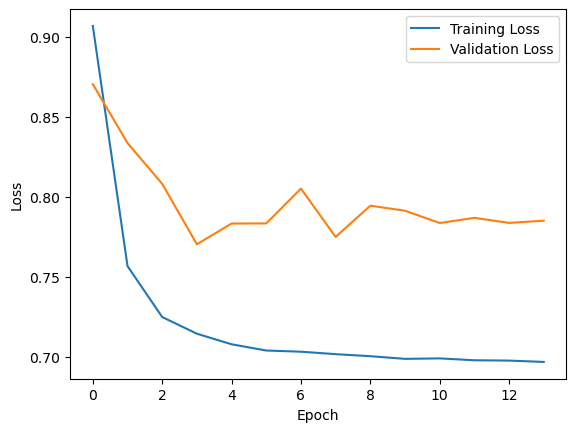

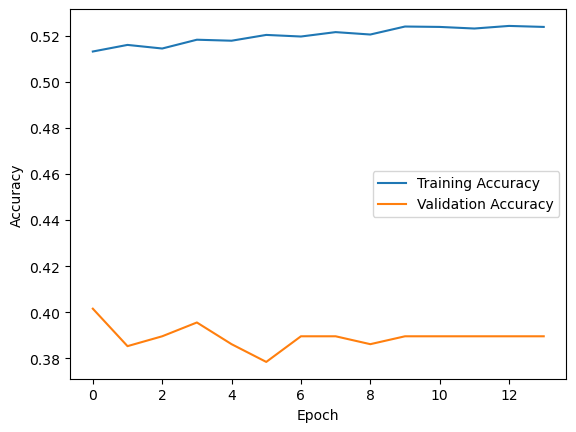

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step
[[0.5966633 ]
 [0.5966633 ]
 [0.6902353 ]
 ...
 [0.5966633 ]
 [0.59666526]
 [0.59116673]]


In [18]:
# Evaluate the model on the test set
test_loss, test_accuracy = score_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate predictions for the test set
y_pred = score_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute F1 score
f1 = f1_score(y_test, y_pred)
print(f"Test F1 Score: {f1}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

X_user_features_score = np.array(data['user_features'].tolist())  # User features (x_u)

# Generate user scores s_i
s_i = score_model.predict(X_user_features_score)

print (s_i)

In [19]:
from sklearn.metrics import precision_recall_curve, classification_report

# Get predicted probabilities for the test set
y_pred_proba = score_model.predict(X_test)

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate F1-score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)
print("Class weights:", class_weights)
# Find the threshold that maximizes the F1-score
optimal_threshold = thresholds[np.argmax(f1_scores)]

print(f"Optimal Threshold: {optimal_threshold}")

# Apply the optimal threshold to generate binary predictions
y_pred_optimal = (y_pred_proba > optimal_threshold).astype(int)

# Compute evaluation metrics with the optimal threshold
f1_optimal = f1_score(y_test, y_pred_optimal)
print(f"Test F1 Score (Optimal Threshold): {f1_optimal}")

# Print classification report with the optimal threshold
print(classification_report(y_test, y_pred_optimal, target_names=['Class 0', 'Class 1']))



37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
Class weights: {0.0: 0.8114720110573601, 1.0: 1.3026403372531616}
Optimal Threshold: 0.26516056060791016
Test F1 Score (Optimal Threshold): 0.5532451165721487
              precision    recall  f1-score   support

     Class 0       0.73      0.04      0.07       726
     Class 1       0.39      0.98      0.55       449

    accuracy                           0.40      1175
   macro avg       0.56      0.51      0.31      1175
weighted avg       0.60      0.40      0.26      1175



# Challenges:
Due to time restrictions and needing to focus on other models, the Score module was unable to be made with higher accuracy rates, even after hours of experimentation to improve F1-score and decrease loss rates. This should not affect the final product and comparison too much as this is a unique model created from scratch that was added to the project in an attempt to expand the functionality of the fake news website. The main functions of the website will still be the same.
In future implementations, this model will be vastly improved with better acccuracy rates and F1-scores. 

# Integrate Model

In [20]:
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda, Reshape
from tensorflow.keras.models import Model
import tensorflow as tf

def build_integrate_module(capture_output_dim=100, score_output_dim=1):
    # Input layers
    v_j_input = Input(shape=(capture_output_dim,), name='v_j_input')  # Article representation from Capture module
    s_i_input = Input(shape=(1,), name='s_i_input')  # User scores from Score module (variable length)
    mask_input = Input(shape=(None,), name='mask_input', dtype=tf.bool)  # Mask for user engagements

    # Expand s_i_input to match the shape of mask_input
    s_i_input_expanded = Lambda(
        lambda x: tf.tile(x[0], [1, tf.shape(x[1])[1]]),  # Tile s_i_input to match mask_input's second dimension
        #output_shape=(None, 3130),  # Explicitly specify the output shape
        output_shape=lambda input_shapes: (input_shapes[0][0], input_shapes[1][1]),  # Define output shape explicitly
        name='expand_s_i_input'
    )([s_i_input, mask_input])

    # Masking: Select user scores for users who engaged with the article
    s_i_masked = Lambda(
        lambda x: tf.ragged.boolean_mask(x[0], x[1]),
        output_shape=(None,),  # Output shape is variable
        name='masking_layer'
    )([s_i_input_expanded, mask_input])

    # Debugging: Print shape of masked output
    s_i_masked_debug = Lambda(
        lambda x: tf.print("s_i_masked:", tf.shape(x)),
        output_shape=(None,),  # Match the shape of s_i_masked
        name='s_i_masked_debug'
    )(s_i_masked)

    # Debugging: Print shape of mask input
    mask_input_debug = Lambda(
        lambda x: tf.print("mask_input:", tf.shape(x)),
        output_shape=(None,),  # Match the shape of mask_input
        name='mask_input_debug'
    )(mask_input)

    # Averaging: Compute the average suspiciousness score for the article
    s_i_avg = Lambda(
        lambda x: tf.reduce_mean(x, axis=1),
        output_shape=(1,),  # Output shape is a scalar (average score)
        name='averaging_layer'
    )(s_i_masked)

    # Reshape s_i_avg to make it rank 2 (shape (None, 1))
    s_i_avg_reshaped = Reshape((1,))(s_i_avg)

    # Concatenation: Combine the averaged suspiciousness score with the article's vector
    concatenated = Concatenate()([v_j_input, s_i_avg_reshaped])

    # Prediction: Fully connected layer to predict the label
    hidden_layer = Dense(64, activation='relu')(concatenated)
    output = Dense(1, activation='sigmoid', name='output')(hidden_layer)

    # Define the model
    model = Model(inputs=[v_j_input, s_i_input, mask_input], outputs=output)
    return model

# Flatten user scores
#s_i = s_i.flatten()  # Shape: [n_users]

# Split s_i into training and validation sets
s_i_train, s_i_val = train_test_split(s_i, test_size=0.2, random_state=42)

# Verify shapes
print("Shape of s_i_train:", s_i_train.shape)
print("Shape of s_i_val:", s_i_val.shape)
#print("Shape of mask_train:", mask_train.shape)  # Should be (9217, 3130)

# Get unique article IDs and user IDs
article_ids = data['id'].unique()
user_ids = data['speaker'].unique()

# Create a mapping from article/user IDs to indices
article_id_to_idx = {id: idx for idx, id in enumerate(article_ids)}
user_id_to_idx = {id: idx for idx, id in enumerate(user_ids)}

# Initialize the engagement matrix with zeros
engagement_matrix = np.zeros((len(article_ids), len(user_ids)), dtype=int)

# Populate the engagement matrix
for _, row in data.iterrows():
    article_idx = article_id_to_idx[row['id']]
    user_idx = user_id_to_idx[row['speaker']]
    engagement_matrix[article_idx, user_idx] = 1  # Mark engagement

# Create a mask for each article
mask = engagement_matrix.astype(bool)  # Shape: [n_articles, n_users]

integrate_model = build_integrate_module(capture_output_dim=100, score_output_dim=1)


Shape of s_i_train: (9393, 1)
Shape of s_i_val: (2349, 1)


In [21]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np

# Build the Integrate module
#integrate_model = build_integrate_module(capture_output_dim=100, score_output_dim=1)

# Compile the CSI model
csi_model = Model(
    inputs=[capture_model.input, score_model.input, integrate_model.input],  # Include all integrate_model inputs
    outputs=integrate_model.output
)

# Define the loss function (log loss + regularization)
loss_fn = BinaryCrossentropy()
regularization_loss = l2(0.01)  # L2 regularization term

# Compile the model
# optimizer = Adam(learning_rate=0.001)
# csi_model.compile(optimizer=optimizer, loss=loss_fn)

csi_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Ensure y_train is created from the same data as input features
y_train_csi = data.loc[train_data.index, 'label_binary'].values  # Use the same indices as input features

# Filter input features to match y_train
X_eta_filtered = X_eta[:len(y_train_csi)]
X_delta_t_filtered = X_delta_t[:len(y_train_csi)]
X_user_features_filtered = X_user_features[:len(y_train_csi)]
X_text_vector_filtered = X_text_vector[:len(y_train_csi)]

# Combine filtered input features
X_combined = np.hstack([X_eta_filtered, X_delta_t_filtered, X_user_features_filtered, X_text_vector_filtered])

# Verify shapes
print("Shape of X_combined:", X_combined.shape)  # Should be (n_samples, n_features)
print("Shape of y_train_csi:", y_train_csi.shape)  # Should be (n_samples,)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_combined_balanced, y_train_rebalanced = smote.fit_resample(X_combined, y_train_csi)

# Split the balanced data back into individual features
X_eta_balanced = X_combined_balanced[:, :1]  # First column: X_eta
X_delta_t_balanced = X_combined_balanced[:, 1:2]  # Second column: X_delta_t
X_user_features_balanced = X_combined_balanced[:, 2:22]  # Next 20 columns: X_user_features
X_text_vector_balanced = X_combined_balanced[:, 22:]  # Remaining columns: X_text_vector

# Generate user scores s_i
s_i = score_model.predict(X_user_features_balanced)

# Flatten s_i to match the shape of other input features
s_i = s_i.flatten()

# Reshape s_i to a 2D tensor of shape (None, 1)
s_i = np.expand_dims(s_i, axis=-1)  # or use tf.expand_dims(s_i, axis=-1)

# Verify shape
print("Shape of s_i after reshaping:", s_i.shape)  # Should be (n_samples, 1)

# Create a mask for user engagements (assuming engagement_matrix is already defined)
mask_balanced = engagement_matrix[:len(y_train_rebalanced)]


# Generate v_j_input using the balanced dataset
v_j_input = capture_model.predict([X_eta_balanced, X_delta_t_balanced, 
                                   X_user_features_balanced, 
                                   X_text_vector_balanced])

# Verify shape
print("Shape of v_j_input:", v_j_input.shape)  # Should be (11522, 100)



Shape of X_combined: (9399, 122)
Shape of y_train_csi: (9399,)
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
Shape of s_i after reshaping: (11522, 1)
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Shape of v_j_input: (11522, 100)


In [22]:
# # Print the model summary#
# #capture_model.summary()

# # Inspect the inputs
# print("Capture model inputs:", capture_model.input)

# #score_model.summary()

# # Inspect the inputs
# print("Score model inputs:", score_model.input)


# print("Integrate model inputs:", integrate_model.input)

# print("CSI model inputs:", csi_model.input)

In [23]:
# Split the balanced data into training and validation sets
from sklearn.model_selection import train_test_split

# Step 1: Split the data into training + validation (80%) and test (20%)
(
    X_eta_train_val, X_eta_test,
    X_delta_t_train_val, X_delta_t_test,
    X_user_features_train_val, X_user_features_test,
    X_text_vector_train_val, X_text_vector_test,
    v_j_input_train_val, v_j_input_test,
    s_i_train_val, s_i_test,
    mask_train_val, mask_test,
    y_train_val, y_test
) = train_test_split(
    X_eta_balanced, X_delta_t_balanced, X_user_features_balanced, 
    X_text_vector_balanced,
    v_j_input,  # Include v_j_input in the split
    s_i, mask_balanced, y_train_rebalanced, test_size=0.2, random_state=42
)

# Step 2: Split the training + validation set into training (80%) and validation (20%)
(
    X_eta_train, X_eta_val,
    X_delta_t_train, X_delta_t_val,
    X_user_features_train, X_user_features_val,
    X_text_vector_train, X_text_vector_val,
    v_j_input_train, v_j_input_val,
    s_i_train, s_i_val,
    mask_train, mask_val,
    y_train, y_val
) = train_test_split(
    X_eta_train_val, X_delta_t_train_val, X_user_features_train_val, 
    X_text_vector_train_val,
    v_j_input_train_val, s_i_train_val, mask_train_val, y_train_val, test_size=0.25, random_state=42
)

print("Training set sizes:")
print("X_eta_train:", X_eta_train.shape)
print("X_delta_t_train:", X_delta_t_train.shape)
print("X_user_features_train:", X_user_features_train.shape)
print("X_text_vector_train:", X_text_vector_train.shape)
print("v_j_input_train:", v_j_input_train.shape)
print("s_i_train:", s_i_train.shape)
print("mask_train:", mask_train.shape)
print("y_train:", y_train.shape)

print("\nValidation set sizes:")
print("X_eta_val:", X_eta_val.shape)
print("X_delta_t_val:", X_delta_t_val.shape)
print("X_user_features_val:", X_user_features_val.shape)
print("X_text_vector_val:", X_text_vector_val.shape)
print("v_j_input_val:", v_j_input_val.shape)
print("s_i_val:", s_i_val.shape)
print("mask_val:", mask_val.shape)
print("y_val:", y_val.shape)

print("\nTest set sizes:")
print("X_eta_test:", X_eta_test.shape)
print("X_delta_t_test:", X_delta_t_test.shape)
print("X_user_features_test:", X_user_features_test.shape)
print("X_text_vector_test:", X_text_vector_test.shape)
print("v_j_input_test:", v_j_input_test.shape)
print("s_i_test:", s_i_test.shape)
print("mask_test:", mask_test.shape)
print("y_test:", y_test.shape)

# Verify shapes
# print("Shape of X_eta_train:", X_eta_train.shape)
# print("Shape of X_delta_t_train:", X_delta_t_train.shape)
# print("Shape of X_user_features_train:", X_user_features_train.shape)
# print("Shape of X_text_vector_train:", X_text_vector_train.shape)
# print("Shape of s_i_train:", s_i_train.shape)
# print("Shape of mask_train:", mask_train.shape)
# print("Shape of y_train:", y_train.shape)

# print("Shape of v_j_input_train:", v_j_input_train.shape)
#print("s_i_train, mask_train:", s_i_train, mask_train.shape)


#s_i_train = np.squeeze(s_i_train, axis=-1)  # Removes the last dimension

# Verify shape
print("Shape of s_i_train after squeezing:", s_i_train.shape)  # Should be (9217, 1)

# Reshape s_i_train to a 2D array of shape (9217, 1)
s_i_train = np.expand_dims(s_i_train, axis=-1)

# Verify shape
print("Shape of s_i_train after reshaping:", s_i_train.shape)  # Should be (9217, 1)

# Broadcast s_i_train to match the shape of mask_train
#s_i_train = np.broadcast_to(s_i_train, (s_i_train.shape[0], mask_train.shape[1]))

#print("Shape of s_i_train after reshaping:", s_i_train.shape) 
# Verify shape
# print("Shape of s_i_train after broadcasting:", s_i_train.shape)  # Should be (9217, 3130)
# print("Shape of mask_train:", mask_train.shape)
# print("Missing values in s_i_train:", np.isnan(s_i_train).sum())
# print("Missing values in mask_train:", np.isnan(mask_train).sum())

Training set sizes:
X_eta_train: (6912, 1)
X_delta_t_train: (6912, 1)
X_user_features_train: (6912, 20)
X_text_vector_train: (6912, 100)
v_j_input_train: (6912, 100)
s_i_train: (6912, 1)
mask_train: (6912, 3130)
y_train: (6912,)

Validation set sizes:
X_eta_val: (2305, 1)
X_delta_t_val: (2305, 1)
X_user_features_val: (2305, 20)
X_text_vector_val: (2305, 100)
v_j_input_val: (2305, 100)
s_i_val: (2305, 1)
mask_val: (2305, 3130)
y_val: (2305,)

Test set sizes:
X_eta_test: (2305, 1)
X_delta_t_test: (2305, 1)
X_user_features_test: (2305, 20)
X_text_vector_test: (2305, 100)
v_j_input_test: (2305, 100)
s_i_test: (2305, 1)
mask_test: (2305, 3130)
y_test: (2305,)
Shape of s_i_train after squeezing: (6912, 1)
Shape of s_i_train after reshaping: (6912, 1, 1)


In [24]:
# Compile the integrate_model
integrate_model.compile(
    optimizer=Adam(learning_rate=0.001),  # Use Adam optimizer
    loss='binary_crossentropy',           # Binary cross-entropy loss
    metrics=['accuracy']                  # Monitor accuracy
)

# # Example: Prepare inputs for training
# v_j_input_train = capture_model.predict([X_eta_train, X_delta_t_train, X_user_features_train, X_text_vector_train])
# s_i_train = score_model.predict(X_user_features_train)
# mask_train = engagement_matrix[:len(v_j_input_train)]  # Ensure the mask matches the number of articles

# # Example: Prepare inputs for validation
# v_j_input_val = capture_model.predict([X_eta_val, X_delta_t_val, X_user_features_val, X_text_vector_val])
# s_i_val = score_model.predict(X_user_features_val)
# mask_val = engagement_matrix[len(v_j_input_train):len(v_j_input_train) + len(v_j_input_val)]  # Ensure the mask matches the number of articles

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Fit the integrate_model
history = integrate_model.fit(
    [v_j_input_train, s_i_train, mask_train],  # Inputs: v_j, s_i, mask
    y_train,                                   # Target labels
    epochs=50,                                 # Number of epochs
    batch_size=32,                             # Batch size
    validation_data=(
        [v_j_input_val, s_i_val, mask_val],    # Validation inputs
        y_val                                  # Validation labels
    ),
    callbacks=[early_stopping, lr_scheduler],  # Callbacks
    verbose=1                                  # Show progress
)

Epoch 1/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5013 - loss: 0.6967 - val_accuracy: 0.4941 - val_loss: 0.6959 - learning_rate: 0.0010
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5071 - loss: 0.6941 - val_accuracy: 0.4911 - val_loss: 0.7261 - learning_rate: 0.0010
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5169 - loss: 0.6950 - val_accuracy: 0.5141 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5063 - loss: 0.6939 - val_accuracy: 0.5098 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5206 - loss: 0.6932 - val_accuracy: 0.5167 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5196 - loss: 0.6918 - val_accuracy: 0.5115 - val_loss: 0.6925 - learning_rate: 0.0010
Epoch 7/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5164 - loss: 0.6936 - 

In [25]:
# # Prepare test inputs
# v_j_input_test = capture_model.predict([X_eta_test, X_delta_t_test, X_user_features_test, X_text_vector_test])
# s_i_test = score_model.predict(X_user_features_test)
# mask_test = engagement_matrix[len(v_j_input_train) + len(v_j_input_val):]  # Ensure the mask matches the number of articles

# Evaluate the model
test_loss, test_accuracy = integrate_model.evaluate(
    [v_j_input_test, s_i_test, mask_test],  # Test inputs
    y_test                                  # Test labels
)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - accuracy: 0.5111 - loss: 0.6923
Test Loss: 0.6915218830108643
Test Accuracy: 0.5140997767448425


In [26]:
#integrate_model.summary()

# # Generate predictions
predictions = integrate_model.predict([v_j_input_val, s_i_val, mask_val])

# Print the predictions
print("Predictions:", predictions)
# # print("Shape of s_i_train:", s_i_train.shape)  # Should be (9217, 1)
# # print("Shape of mask_train:", mask_train.shape)  # Should be (9217, 3130)
# # # Example: Create a mask where users who engaged with an article are marked as True
# # #mask_train = (engagement_matrix > 0).astype(bool)  # Shape: (9217, 3130)

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Predictions: [[0.47007194]
 [0.5059475 ]
 [0.50012505]
 ...
 [0.53274375]
 [0.46365112]
 [0.4885559 ]]


In [27]:
# Train the CSI model
history = csi_model.fit(
    [
        X_eta_train, X_delta_t_train, X_user_features_train, 
        X_text_vector_train,  # Capture model inputs      
        X_user_features_train,  # Score model input (shape (None, 20))       
        v_j_input_train, 
        s_i_train, mask_train  # Integrate model inputs
    ],
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(
        [
            X_eta_val, X_delta_t_val, X_user_features_val, 
            X_text_vector_val,  # Capture model inputs
            X_user_features_val,  # Score model input (shape (None, 20))
            v_j_input_val, 
            s_i_val, mask_val  # Integrate model inputs
        ],
        y_val
    ),
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5024 - loss: 0.7058 - val_accuracy: 0.4924 - val_loss: 0.7340 - learning_rate: 0.0010
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5019 - loss: 0.7022 - val_accuracy: 0.4924 - val_loss: 0.7347 - learning_rate: 0.0010
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5021 - loss: 0.7030 - val_accuracy: 0.4924 - val_loss: 0.7332 - learning_rate: 0.0010
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5000 - loss: 0.7031 - val_accuracy: 0.4933 - val_loss: 0.7237 - learning_rate: 0.0010
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4913 - loss: 0.7053 - val_accuracy: 0.4924 - val_loss: 0.7537 - learning_rate: 0.0010
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5090 - loss: 0.7026 - val_accuracy: 0.4941 - val_loss: 0.7050 - learning_rate: 0.0010
Epoch 7/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5071 - loss: 0.7010 - 

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

# Define 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
accuracy_scores = []
f1_scores = []

for train_index, test_index in kf.split(X_eta_balanced, y_train_rebalanced):
    # Split data into train (80%), val (5%), and test (15%)
    train_size = int(len(train_index) * 0.8)
    val_size = int(len(train_index) * 0.05)

    train_idx, val_idx = train_index[:train_size], train_index[train_size:train_size + val_size]
    test_idx = test_index  # 15% test set

    # Prepare data for this fold
    X_eta_train, X_eta_val, X_eta_test = X_eta_balanced[train_idx], X_eta_balanced[val_idx], X_eta_balanced[test_idx]
    X_delta_t_train, X_delta_t_val, X_delta_t_test = X_delta_t_balanced[train_idx], X_delta_t_balanced[val_idx], X_delta_t_balanced[test_idx]
    X_user_features_train, X_user_features_val, X_user_features_test = X_user_features_balanced[train_idx], X_user_features_balanced[val_idx], X_user_features_balanced[test_idx]
    X_text_vector_train, X_text_vector_val, X_text_vector_test = X_text_vector_balanced[train_idx], X_text_vector_balanced[val_idx], X_text_vector_balanced[test_idx]
    v_j_train, v_j_val, v_j_test = v_j_input[train_idx], v_j_input[val_idx], v_j_input[test_idx]
    s_i_train, s_i_val, s_i_test = s_i[train_idx], s_i[val_idx], s_i[test_idx]
    mask_train, mask_val, mask_test = mask_balanced[train_idx], mask_balanced[val_idx], mask_balanced[test_idx]
    y_train, y_val, y_test = y_train_rebalanced[train_idx], y_train_rebalanced[val_idx], y_train_rebalanced[test_idx]

    # Rebuild CSI Model for each fold
    csi_model = Model(inputs=[capture_model.input, score_model.input, integrate_model.input], outputs=integrate_model.output)
    csi_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train model
    csi_model.fit(
        [
            X_eta_train, X_delta_t_train, X_user_features_train, X_text_vector_train,  # Capture module
            X_user_features_train,  # Score module
            v_j_train, s_i_train, mask_train  # Integrate module
        ],
        y_train,
        epochs=50,
        batch_size=32,
        validation_data=(
            [
                X_eta_val, X_delta_t_val, X_user_features_val, X_text_vector_val,
                X_user_features_val, v_j_val, s_i_val, mask_val
            ],
            y_val
        ),
        class_weight=class_weights,
        callbacks=[early_stopping, lr_scheduler]
    )

    # Evaluate on test set
    y_pred = csi_model.predict([
        X_eta_test, X_delta_t_test, X_user_features_test, X_text_vector_test,  
        X_user_features_test, v_j_test, s_i_test, mask_test  
    ])
    y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

    # Compute accuracy & F1-score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

    print(f"Fold Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}")



Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4954 - loss: 0.6969 - val_accuracy: 0.3087 - val_loss: 0.7022 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5183 - loss: 0.6947 - val_accuracy: 0.2717 - val_loss: 0.7228 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4839 - loss: 0.6976 - val_accuracy: 0.7674 - val_loss: 0.6730 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4939 - loss: 0.6937 - val_accuracy: 0.4022 - val_loss: 0.6944 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4958 - loss: 0.6971 - val_accuracy: 0.2174 - val_loss: 0.7591 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4950 - loss: 0.6947 - val_accuracy: 0.6348 - val_loss: 0.6870 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4984 - loss: 0.6950 - 

In [29]:
# Print final cross-validation results
print(f"\nFinal 5-Fold Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
print(f"Final 5-Fold F1-score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")



Final 5-Fold Accuracy: 0.5135 ± 0.0047
Final 5-Fold F1-score: 0.6626 ± 0.0045


In [30]:
# print("Unique Predictions:", np.unique(y_pred, return_counts=True))
# print("Class Distribution After SMOTE:", np.bincount(y_train_rebalanced))


In [31]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import accuracy_score, f1_score
# import numpy as np

# # Combine all input features into a single array for easier splitting
# X_combined = np.hstack([X_eta, X_delta_t, X_user_features, X_text_vector])
# y = data['label_binary'].values  # Target labels

# # Initialize KFold for 5-fold cross-validation
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Lists to store evaluation metrics
# accuracy_scores = []
# f1_scores = []

# # Perform 5-fold cross-validation
# for fold, (train_index, test_index) in enumerate(kf.split(X_combined)):
#     print(f"Fold {fold + 1}")

#     # Split data into training and test sets
#     X_train, X_test = X_combined[train_index], X_combined[test_index]
#     y_train, y_test = y[train_index], y[test_index]

#     # Further split training data into training and validation sets (80% training, 5% validation)
#     train_size = int(0.8 * len(X_train))
#     X_train_fold, X_val_fold = X_train[:train_size], X_train[train_size:]
#     y_train_fold, y_val_fold = y_train[:train_size], y_train[train_size:]

#     # Split X_train_fold into individual features
#     X_eta_train_fold = X_train_fold[:, :1]
#     X_delta_t_train_fold = X_train_fold[:, 1:2]
#     X_user_features_train_fold = X_train_fold[:, 2:22]
#     X_text_vector_train_fold = X_train_fold[:, 22:]

#     # Split X_val_fold into individual features
#     X_eta_val_fold = X_val_fold[:, :1]
#     X_delta_t_val_fold = X_val_fold[:, 1:2]
#     X_user_features_val_fold = X_val_fold[:, 2:22]
#     X_text_vector_val_fold = X_val_fold[:, 22:]

#     # Split X_test into individual features
#     X_eta_test = X_test[:, :1]
#     X_delta_t_test = X_test[:, 1:2]
#     X_user_features_test = X_test[:, 2:22]
#     X_text_vector_test = X_test[:, 22:]

#     # Generate v_j_input for training, validation, and test sets
#     v_j_input_train_fold = capture_model.predict([X_eta_train_fold, X_delta_t_train_fold, 
#                                                  X_user_features_train_fold, X_text_vector_train_fold])
#     v_j_input_val_fold = capture_model.predict([X_eta_val_fold, X_delta_t_val_fold, 
#                                                X_user_features_val_fold, X_text_vector_val_fold])
#     v_j_input_test = capture_model.predict([X_eta_test, X_delta_t_test, 
#                                            X_user_features_test, X_text_vector_test])

#     # Generate s_i for training, validation, and test sets
#     s_i_train_fold = score_model.predict(X_user_features_train_fold)
#     s_i_val_fold = score_model.predict(X_user_features_val_fold)
#     s_i_test = score_model.predict(X_user_features_test)

#     # Create masks for training, validation, and test sets
#     mask_train_fold = engagement_matrix[train_index[:train_size]]
#     mask_val_fold = engagement_matrix[train_index[train_size:]]
#     mask_test = engagement_matrix[test_index]
    
#     # Reshape s_i to (None, 1)
# #     s_i_train_fold = np.reshape(s_i_train_fold, (-1, 1))
# #     s_i_val_fold = np.reshape(s_i_val_fold, (-1, 1))

# #     # Ensure mask is a 2D array
# #     mask_train_fold = np.reshape(mask_train_fold, (len(X_eta_train_fold), -1))
# #     mask_val_fold = np.reshape(mask_val_fold, (len(X_eta_val_fold), -1))

#     # Train the CSI model
#     history = csi_model.fit(
#         [
#             X_eta_train_fold, X_delta_t_train_fold, X_user_features_train_fold, X_text_vector_train_fold,  # Capture inputs
#             X_user_features_train_fold,  # Score input
#             v_j_input_train_fold, s_i_train_fold, mask_train_fold  # Integrate inputs
#         ],
#         y_train_fold,
#         epochs=50,
#         batch_size=32,
#         validation_data=(
#             [
#                 X_eta_val_fold, X_delta_t_val_fold, X_user_features_val_fold, X_text_vector_val_fold,  # Capture inputs
#                 X_user_features_val_fold,  # Score input
#                 v_j_input_val_fold, s_i_val_fold, mask_val_fold  # Integrate inputs
#             ],
#             y_val_fold
#         ),
#         class_weight=class_weights,
#         callbacks=[early_stopping, lr_scheduler],
#         verbose=1
#     )

#     # Evaluate the model on the test set
#     y_pred = csi_model.predict(
#         [
#             X_eta_test, X_delta_t_test, X_user_features_test, X_text_vector_test,  # Capture inputs
#             X_user_features_test,  # Score input
#             v_j_input_test, s_i_test, mask_test  # Integrate inputs
#         ]
#     )
#     y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

#     # Compute metrics
#     accuracy = accuracy_score(y_test, y_pred_binary)
#     f1 = f1_score(y_test, y_pred_binary)

#     # Store metrics
#     accuracy_scores.append(accuracy)
#     f1_scores.append(f1)

#     print(f"Fold {fold + 1} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

# # Aggregate results
# print("\nCross-Validation Results:")
# print(f"Average Accuracy: {np.mean(accuracy_scores):.4f} (±{np.std(accuracy_scores):.4f})")
# print(f"Average F1 Score: {np.mean(f1_scores):.4f} (±{np.std(f1_scores):.4f})")

In [32]:
# print("Shapes of inputs to csi_model.fit:")
# print("X_eta_train_fold:", X_eta_train_fold.shape)
# print("X_delta_t_train_fold:", X_delta_t_train_fold.shape)
# print("X_user_features_train_fold:", X_user_features_train_fold.shape)
# print("X_text_vector_train_fold:", X_text_vector_train_fold.shape)
# print("v_j_input_train_fold:", v_j_input_train_fold.shape)
# print("s_i_train_fold:", s_i_train_fold.shape)
# print("mask_train_fold:", mask_train_fold.shape)
# print("y_train_fold:", y_train_fold.shape)

# print("Shapes of validation inputs:")
# print("X_eta_val_fold:", X_eta_val_fold.shape)
# print("X_delta_t_val_fold:", X_delta_t_val_fold.shape)
# print("X_user_features_val_fold:", X_user_features_val_fold.shape)
# print("X_text_vector_val_fold:", X_text_vector_val_fold.shape)
# print("v_j_input_val_fold:", v_j_input_val_fold.shape)
# print("s_i_val_fold:", s_i_val_fold.shape)
# print("mask_val_fold:", mask_val_fold.shape)
# print("y_val_fold:", y_val_fold.shape)

In [33]:
# LAST THING: EVALUATE AND TEST MODEL

In [34]:
# # Evaluate the CSI model
# test_loss, test_accuracy = csi_model.evaluate(
#     [X_eta_test, X_delta_t_test, X_user_features_test, X_text_vector_test, s_i_test, mask_test],
#     y_test
# )
# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_accuracy}")

# # Generate predictions
# y_pred_proba = csi_model.predict(
#     [X_eta_test, X_delta_t_test, X_user_features_test, X_text_vector_test, s_i_test, mask_test]
# )

# # Apply the optimal threshold to generate binary predictions
# y_pred_optimal = (y_pred_proba > optimal_threshold).astype(int)

# # Compute F1 score with the optimal threshold
# f1_optimal = f1_score(y_test, y_pred_optimal)
# print(f"Test F1 Score (Optimal Threshold): {f1_optimal}")

# # Print classification report with the optimal threshold
# print(classification_report(y_test, y_pred_optimal, target_names=['Class 0', 'Class 1']))

In [35]:
#